# Predict Credit Consumption of Customer For Leading Bank
_Assignment from Analytix Labs_   
-Part1: Cleaning and SUM/MAX/LABEL

# Setup

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [4, 4]

# Consumption
- I am selecting only rows for which consumption is available to store in FE
- For other dataframes I will process all rows

In [2]:
consumption = pd.read_excel("data/CreditConsumptionData.xlsx")
consumption = consumption[consumption['cc_cons'].notna()]
consumption.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       15000 non-null  int64  
 1   cc_cons  15000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 351.6 KB


<Axes: xlabel='cc_cons', ylabel='Density'>

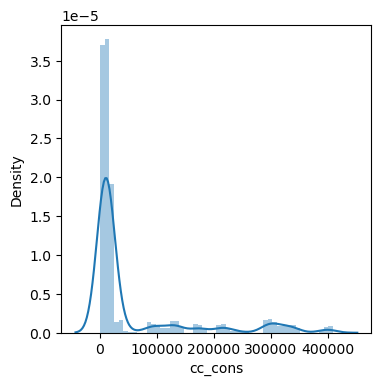

In [3]:
sns.distplot(consumption['cc_cons'])

In [4]:
## This does not fit any reasonable distribution like sqrt, cbrt or log therefore
from sklearn.preprocessing import quantile_transform
X = consumption[['cc_cons']].values
cc_cons_new = quantile_transform(X, n_quantiles=len(X), output_distribution='uniform', copy=True)
consumption['cc_cons_quantileTransformed'] = cc_cons_new
consumption.head()

,ID,cc_cons,cc_cons_quantileTransformed
0,12554,20014.0,0.747450
1,17645,10173.0,0.377158
2,7604,16095.0,0.602173
3,1590,7707.0,0.284819
4,16556,96408.0,0.814454


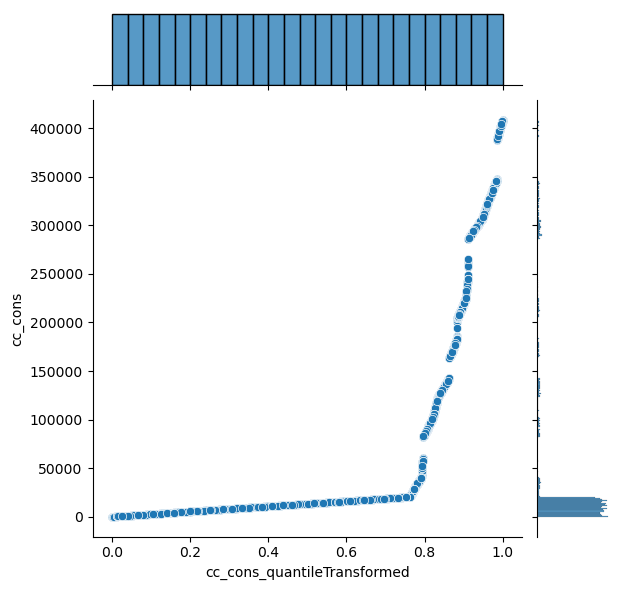

In [5]:
sns.jointplot(x=consumption['cc_cons_quantileTransformed'], y=consumption['cc_cons'])
consumption.to_csv("FE/consumption_withQN.csv", index=False)

# Demographics

In [6]:
## import data
demographics = pd.read_excel("data/CustomerDemographics.xlsx")
demographics.info()
## demographics['ID'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


- drop the one null in account_type
- drop the one null in gender
- drop the one null in Income
- drop the one null in region_code
- drop the nulls in Avg_days_between_transaction

In [7]:
demographics = demographics[demographics['account_type'].notna()]
demographics = demographics[demographics['gender'].notna()]
demographics = demographics[demographics['Income'].notna()]
demographics = demographics[demographics['region_code'].notna()]
demographics = demographics[demographics['Avg_days_between_transaction'].notna()]
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19993 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            19993 non-null  int64  
 1   account_type                  19993 non-null  object 
 2   gender                        19993 non-null  object 
 3   age                           19993 non-null  int64  
 4   Income                        19993 non-null  object 
 5   Emp_Tenure_Years              19993 non-null  float64
 6   Tenure_with_Bank              19993 non-null  int64  
 7   region_code                   19993 non-null  float64
 8   NetBanking_Flag               19993 non-null  int64  
 9   Avg_days_between_transaction  19993 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.7+ MB


## binary data feilds
- account_type (make is_savings)
- gender (make is_female)

In [8]:
demographics['FE_isSaving'] = np.where(demographics['account_type'] == "saving", 1,0)
demographics['FE_isFemale'] = np.where(demographics['gender'] == "F", 1,0)
demographics.drop(columns = ['account_type','gender'], inplace=True)
demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19993 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            19993 non-null  int64  
 1   age                           19993 non-null  int64  
 2   Income                        19993 non-null  object 
 3   Emp_Tenure_Years              19993 non-null  float64
 4   Tenure_with_Bank              19993 non-null  int64  
 5   region_code                   19993 non-null  float64
 6   NetBanking_Flag               19993 non-null  int64  
 7   Avg_days_between_transaction  19993 non-null  float64
 8   FE_isSaving                   19993 non-null  int64  
 9   FE_isFemale                   19993 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 1.7+ MB


## Numeric Feilds
- age
- Emp_Tenure_Years
- Tenure_with_Bank

### Age and Emp_tenure_years
- have same entry problems and final decision is to remove them for segmentation purposes


<Axes: xlabel='age', ylabel='Count'>

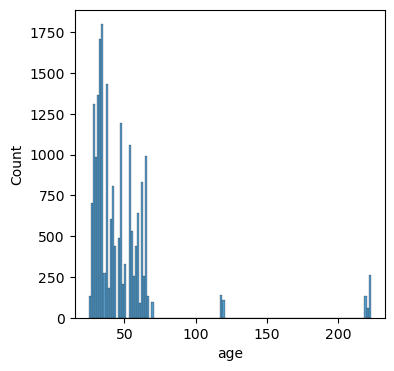

In [9]:
sns.histplot(demographics['age'])

<Axes: xlabel='Emp_Tenure_Years', ylabel='Count'>

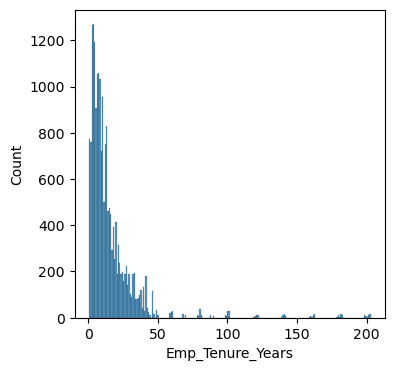

In [10]:
sns.histplot(demographics['Emp_Tenure_Years'])

Text(0.5, 1.0, 'Error values of age vs Emp_Tenure_Years, they may be independent errors')

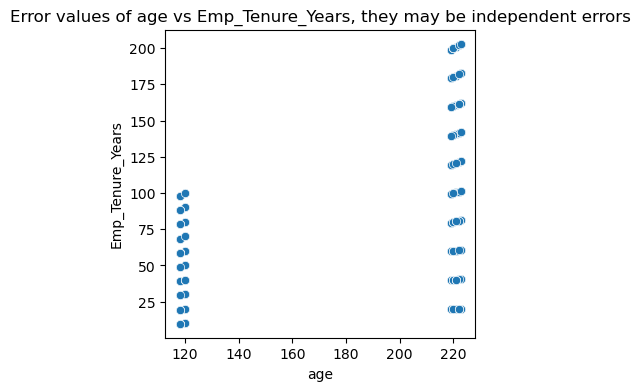

In [11]:
age_tenure_error = demographics[(demographics['age'] > 75) | (demographics['Emp_Tenure_Years'] > 55)]
sns.scatterplot(data = age_tenure_error, x= 'age',y='Emp_Tenure_Years')
plt.title("Error values of age vs Emp_Tenure_Years, they may be independent errors")

#### My choices to handle this error,
- I would discard these rows but they are too many (n=706)
- I would cap them at 75 but not sure if outliers are really > 75.
- I will mark them as nan which allows me to impute them later. Additionally, I will mark them as erratic_age
- I will discard them for the segmentation step 

In [12]:
demographics['FE_age_noOutlierErrors'] = np.where(demographics['age'] < 75, demographics['age'], np.nan)
demographics = demographics[demographics['FE_age_noOutlierErrors'].notna()]
demographics.drop(columns=['age'], inplace=True)

<Axes: xlabel='Emp_Tenure_Years', ylabel='Density'>

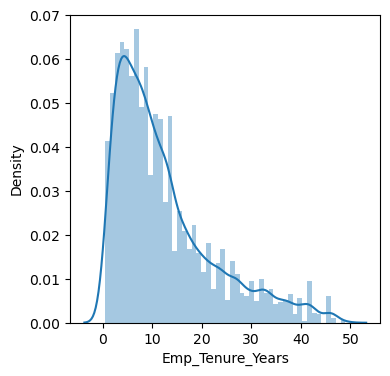

In [13]:
sns.distplot(demographics['Emp_Tenure_Years'])

__Fixing other errors fixed 'Emp_Tenure_Years' also!__

### Tenure_with_Bank

<Axes: xlabel='Tenure_with_Bank', ylabel='Density'>

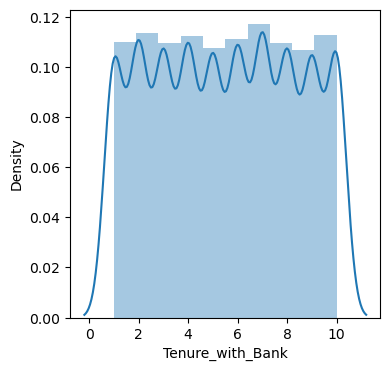

In [14]:
sns.distplot(demographics['Tenure_with_Bank'], bins=10)

In [15]:
### Avg_days_between_transaction

19


<Axes: xlabel='Avg_days_between_transaction', ylabel='Density'>

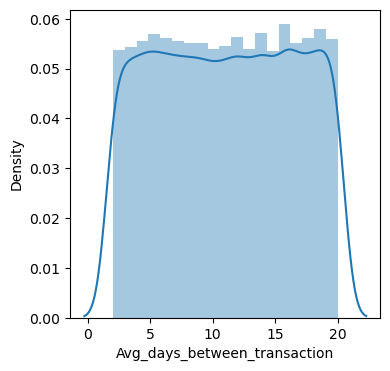

In [16]:
bin_days = demographics['Avg_days_between_transaction'].nunique()
print(bin_days)
sns.distplot(demographics['Avg_days_between_transaction'], bins=bin_days)

## one hot encoding felids
- Income (HIGH/MEDIUM/LOW)
- region_code (they say it is ordinal, needs clubbing and one hot encoding)
- Actual encoding will be done in next step with Feature scaling

### Income
- The income column needs one hot encoding.
- NaN can be replaced by MEDIUM
- first log the column with error

<Axes: xlabel='Income', ylabel='count'>

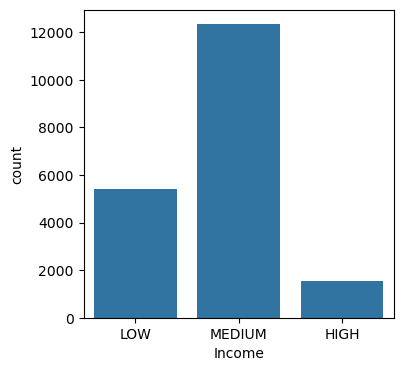

In [17]:
income_order = ['LOW', 'MEDIUM', 'HIGH']
demographics['Income'] = pd.Categorical(demographics['Income'], categories=income_order, ordered=True)
sns.countplot(data=demographics, x='Income', order=income_order)


### region_code
- They say it has order
- There are region codes with fewer than 10% data nothing (segmentation or regression) will work for it.
- I will club them sequentially so that none of them has fewer than 200 individual rows.

Text(0.5, 1.0, 'individuals per region_code before binning')

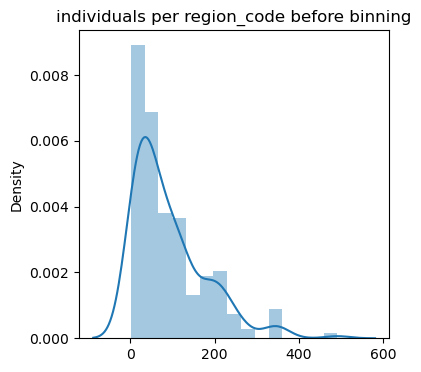

In [18]:
region_code_sizes = demographics.groupby('region_code').size()
sns.distplot(region_code_sizes)
plt.title("individuals per region_code before binning")

__if a category is > 200 let it be independent else merge with next.__

In [19]:
region_sums = demographics.groupby('region_code').size().reset_index(name='count')
region_sums.sort_values(by='region_code', inplace=True)
cumulative_counts = region_sums['count'].cumsum()
n_count = 0
gp = 0
gp_ls = []
for i,row in region_sums.iterrows():
    ##print(row['count'])
    n_count += row['count']
    if n_count-row['count'] < 170:
        gp_ls.append(gp)
        if n_count > 200:
            gp += 1
            n_count = 0
    elif row['count'] > 200:
        gp += 1
        n_count = 0
        gp_ls.append(gp)
    elif n_count >= 200:
        gp_ls.append(gp)
        gp += 1
        n_count = 0
    else:
        gp_ls.append(gp)

region_sums['region_bins'] = gp_ls

region_new_names = region_sums.groupby('region_bins')['region_code'].agg(['min','max']).reset_index()
region_new_names['FE_region_id'] = region_new_names['min'].round(0).astype(str)+"-"+region_new_names['max'].round(0).astype(str)
## region_new_names
## region_sums
region_bins_assign = pd.merge(region_sums, region_new_names, on="region_bins")
region_bins_assign.to_csv("FE/region_bins_assignment_table.csv")
region_bins_assign.drop(columns = ['region_bins', 'min', 'max', 'count'], inplace=True)

Text(0.5, 1.0, 'individuals per FE_region_id after binning')

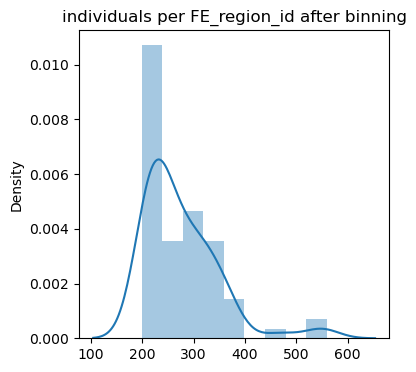

In [20]:
demographics = pd.merge(demographics, region_bins_assign, on='region_code')
## sanity check
region_bin_sizes = demographics.groupby('FE_region_id').size()
## region_bins[region_bins['count'] < 100]
sns.distplot(region_bin_sizes)
plt.title("individuals per FE_region_id after binning")

In [21]:
demographics.to_csv("FE/demographics_cleaned.csv", index=False)
demographics.columns

Index(['ID', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code',
       'NetBanking_Flag', 'Avg_days_between_transaction', 'FE_isSaving',
       'FE_isFemale', 'FE_age_noOutlierErrors', 'FE_region_id'],
      dtype='object')

__I am leaving 'FE_region_id' as it will help if we decide to keep label encoding__

# Customer Behavior Data

In [22]:
behavior = pd.read_excel("data/CustomerBehaviorData.xlsx")
behavior.shape
behavior.columns

Index(['ID', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'personal_loan_active', 'vehicle_loan_active',
       'personal_loan_closed', 'vehicle_loan_closed', 'investment_1',
       'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr',
       'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
       'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
       'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
       'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
       'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active'],
      dtype='object')

## Values to sum
- sum_cc_cons - Credit card spend April, May, June
- sum_dc_cons - Debit card spend April, May, June
- sum_cc_count - Number of credit card transactions in April, May, June
- sum_dc_count - Number of debit card transactions in April, May, June
- sum_debit_amount - Total amount debited for April, May, June
- sum_credit_amount - Total amount credited for April, May, June
- sum_debit_count - Total number of times amount debited in April, May, June
- 

In [23]:
behavior['sum_cc_cons'] = behavior['cc_cons_apr']+behavior['cc_cons_may']+behavior['cc_cons_jun']
behavior.drop(columns = ['cc_cons_apr','cc_cons_may','cc_cons_jun'], inplace=True)

behavior['sum_dc_cons'] = behavior['dc_cons_apr']+behavior['dc_cons_may']+behavior['dc_cons_jun']
behavior.drop(columns = ['dc_cons_apr','dc_cons_may','dc_cons_jun'], inplace=True)

behavior['sum_cc_count'] = behavior['cc_count_apr']+behavior['cc_count_may']+behavior['cc_count_jun']
behavior.drop(columns = ['cc_count_apr','cc_count_may','cc_count_jun'], inplace=True)

behavior['sum_dc_count'] = behavior['dc_count_apr']+behavior['dc_count_may']+behavior['dc_count_jun']
behavior.drop(columns = ['dc_count_apr','dc_count_may','dc_count_jun'], inplace=True)

behavior['sum_debit_amount'] = behavior['debit_amount_apr']+behavior['debit_amount_may']+behavior['debit_amount_jun']
behavior.drop(columns = ['debit_amount_apr','debit_amount_may','debit_amount_jun'], inplace=True)

behavior['sum_credit_amount'] = behavior['credit_amount_apr']+behavior['credit_amount_may']+behavior['credit_amount_jun']
behavior.drop(columns = ['credit_amount_apr','credit_amount_may','credit_amount_jun'], inplace=True)

behavior['sum_debit_count'] = behavior['debit_count_apr'] +behavior['debit_count_may'] +behavior['debit_count_jun'] 
behavior.drop(columns = ['debit_count_apr','debit_count_may','debit_count_jun'], inplace=True)

behavior['sum_credit_count'] = behavior['credit_count_apr'] +behavior['credit_count_may'] +behavior['credit_count_jun'] 
behavior.drop(columns = ['credit_count_apr','credit_count_may','credit_count_jun'], inplace=True)

## Values untouched
- card_lim
- emi_active

## Values to get Max
- MAX_credit_amount - Maximum amount credited in April, May, Jun

In [24]:
behavior['MAX_credit_amount'] = behavior[['max_credit_amount_apr', 'max_credit_amount_may', 'max_credit_amount_jun']].max(axis=1)
behavior.drop(columns = ['max_credit_amount_apr','max_credit_amount_may','max_credit_amount_jun'], inplace=True)

## Values renamed
- investment_1 = trading
- investment_2 = Fixed Deposits or Certificate of Deposits
- investment_3 = Life Insurance
- investment_4 = General Insurance
  \t somehow this has negative values  
  \t how to get a log of them
  \t I will create a new feature for Negative values
- feilds created = Neg_GeneralInsurance, Pos_GeneralInsurance


In [25]:
behavior.rename(columns={'investment_1': 'trading',
                   'investment_2' : 'CDs',
                   'investment_3' : 'LifeInsurance',
                   'investment_4' : 'GeneralInsurance'}, inplace=True)
## 


In [26]:
behavior['Neg_GeneralInsurance'] = np.where(behavior['GeneralInsurance']<0, behavior['GeneralInsurance']*-1, 0)
behavior['Pos_GeneralInsurance'] = np.where(behavior['GeneralInsurance'] >= 0, behavior['GeneralInsurance'], 0)
behavior.drop(columns = ['GeneralInsurance'], inplace=True)

## Non Informative Columns (no variablility)

- Loan_enq - Loan enquiry in last 3 months (Y or N) -- ALL BUT 2
- Personal_loan_active - Active personal loan with other bank -- ALL YES
- Vehicle_loan_active - Active Vehicle loan with other bank -- ALL YES
- Personal_loan_closed - Closed personal loan in last 12 months -- ALL but one!
- Vehicle_loan_closed - Closed vehicle loan in last 12 months -- All 1

In [27]:
behavior.drop(columns = ['loan_enq', 'personal_loan_active', 'vehicle_loan_active','personal_loan_closed','vehicle_loan_closed'], inplace=True)

In [28]:
behavior.to_csv("FE/behavior_cleaned.csv", index=False)
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    20000 non-null  int64  
 1   card_lim              20000 non-null  int64  
 2   trading               20000 non-null  float64
 3   CDs                   20000 non-null  float64
 4   LifeInsurance         19998 non-null  float64
 5   emi_active            19999 non-null  float64
 6   sum_cc_cons           19999 non-null  float64
 7   sum_dc_cons           19999 non-null  float64
 8   sum_cc_count          19999 non-null  float64
 9   sum_dc_count          20000 non-null  int64  
 10  sum_debit_amount      20000 non-null  float64
 11  sum_credit_amount     20000 non-null  float64
 12  sum_debit_count       19999 non-null  float64
 13  sum_credit_count      20000 non-null  int64  
 14  MAX_credit_amount     20000 non-null  float64
 15  Neg_GeneralInsuranc